In [1]:
# import dependencies
%matplotlib inline
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread

# import raw csvs
base_dir = os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities')
all_xray_df = pd.read_csv('input/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
89127,00022132_002.png,Effusion|Pneumothorax,2,22132,57,F,PA,2590,2991,0.143,0.143,NaN
17058,00004577_000.png,No Finding,0,4577,37,M,PA,2048,2500,0.171,0.171,NaN
10857,00002817_011.png,No Finding,11,2817,69,F,PA,2992,2991,0.143,0.143,NaN
69181,00017070_004.png,No Finding,4,17070,61,M,PA,3056,2544,0.139,0.139,NaN
33112,00008689_003.png,No Finding,3,8689,20,M,AP,2500,2048,0.168,0.168,NaN


In [2]:
# info on datatypes and nulls
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
Image Index                    112120 non-null object
Finding Labels                 112120 non-null object
Follow-up #                    112120 non-null int64
Patient ID                     112120 non-null int64
Patient Age                    112120 non-null int64
Patient Gender                 112120 non-null object
View Position                  112120 non-null object
OriginalImage[Width            112120 non-null int64
Height]                        112120 non-null int64
OriginalImagePixelSpacing[x    112120 non-null float64
y]                             112120 non-null float64
Unnamed: 11                    0 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [3]:
# unique combinations in 'Finding Labels'
all_xray_df['Finding Labels'].value_counts()

No Finding                                                                     60361
Infiltration                                                                    9547
Atelectasis                                                                     4215
Effusion                                                                        3955
Nodule                                                                          2705
                                                                               ...  
Fibrosis|Hernia|Mass                                                               1
Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening                        1
Cardiomegaly|Edema|Pleural_Thickening                                              1
Atelectasis|Effusion|Emphysema|Infiltration|Pleural_Thickening|Pneumothorax        1
Consolidation|Edema|Effusion|Pneumonia                                             1
Name: Finding Labels, Length: 836, dtype: int64

In [4]:
# number of "Cardiomegaly" images
all_xray_df['Finding Labels'].str.count('Cardiomegaly').sum()

2776

In [5]:
# number of "No Finding" label
all_xray_df['Finding Labels'].str.count('No Finding').sum()

60361

In [6]:
all_xray_df['Finding Labels'].str.count('Pneumonia').sum()

1431

In [7]:
# percent of images with cardiomegaly compared to no finding
# unbalanced data, cardiomegaly is far more rare than no finding
(2776/60361)*100

4.5989960404897205

### Preprocessing
Organize the files by cases with and without cardiomegaly
There  are 15 classes (14 diseases and one "No Finding"): Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening, cardiomegaly, nodule mass, hernia
Note: Multiple classes can occur in "Finding Labels" column (e.g. Cardiomegaly|Infiltration|Mass|Nodule)

In [8]:
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('input', 'data', 'images*', '*', '*.png'))}
print('Scans found: ', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
# add a column with image paths
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# add a cardiomegaly column (True/False). Is the word "Cardiomegaly" contained in the "Finding Labels" column
all_xray_df['Cardiomegaly'] = all_xray_df['Finding Labels'].map(lambda x: 'Cardiomegaly' in x)
#Clip the upper and lower age boundaries (lower=5, upper=100).  Clean data - remove data outside this range. 
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
# add new column "Patient Male" M = 1.0 and F = 0.0 cast as float
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')
all_xray_df.sample(5)

Scans found:  112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
60747,00015002_002.png,No Finding,2,15002,56,M,PA,2992,2991,0.143,0.143,NaN,input/data/images_007/images/00015002_002.png,False,1.0
95524,00025112_000.png,No Finding,0,25112,62,F,PA,2470,2991,0.143,0.143,NaN,input/data/images_011/images/00025112_000.png,False,0.0
43698,00011251_019.png,Infiltration,19,11251,76,M,AP,2500,2048,0.168,0.168,NaN,input/data/images_005/images/00011251_019.png,False,1.0
13662,00003529_003.png,No Finding,3,3529,50,F,PA,2500,2048,0.168,0.168,NaN,input/data/images_002/images/00003529_003.png,False,0.0
43005,00011097_006.png,No Finding,6,11097,43,M,AP,3056,2544,0.139,0.139,NaN,input/data/images_005/images/00011097_006.png,False,1.0


In [9]:
all_xray_df['Cardiomegaly'].value_counts()

False    109344
True       2776
Name: Cardiomegaly, dtype: int64

In [10]:
# percent cardiomegaly of total
(2776/109344)*100

2.5387767047117356

### Examine the data.  Plot distributions

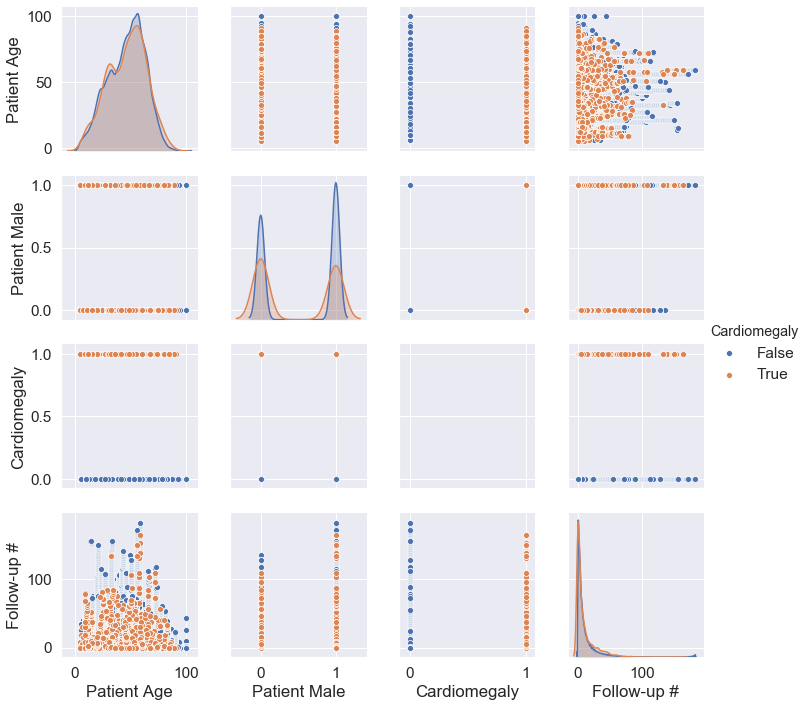

In [237]:
sns_plot = sns.pairplot(all_xray_df[['Patient Age', 'Patient Male', 'Cardiomegaly', 'Follow-up #']], hue='Cardiomegaly')
sns_plot.savefig('output/raw_distributions.png')

### Adjust the negative group to max 4x the positive group to prevent oversampling the negative group

In [12]:
# add a factor to prevent oversampling of negative data
positive_cardiomegaly = np.sum(all_xray_df['Cardiomegaly']==True)//2  # // floor division round down to nearest int
# max number of negative cases...limit the disparity between the positive and negative group (now negative group is only 4x the positive group)
oversample_factor = 4
balanced_df = all_xray_df.groupby(['Patient Gender', 'Cardiomegaly']).apply(lambda x: x.sample(min(oversample_factor*positive_cardiomegaly, x.shape[0]), replace = False)).reset_index(drop = True)
balanced_df['Cardiomegaly'].value_counts()

False    11104
True      2776
Name: Cardiomegaly, dtype: int64

In [13]:
#balanced percent cardiomegaly 25%
(2776/11104)*100

25.0

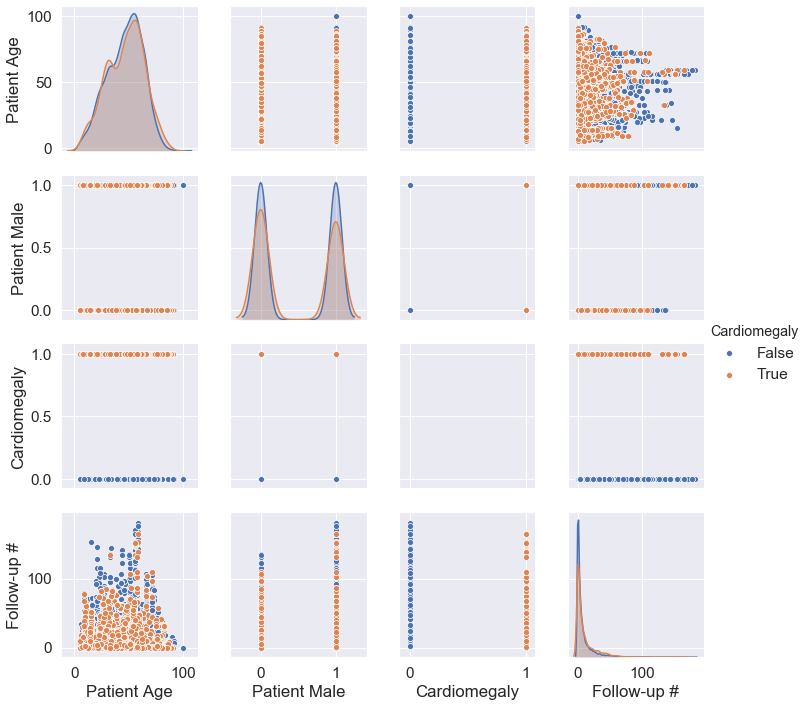

In [238]:
sns_plot_rebalanced = sns.pairplot(balanced_df[['Patient Age', 'Patient Male', 'Cardiomegaly', 'Follow-up #']], hue='Cardiomegaly')
sns_plot_rebalanced.savefig('output/rebalanced_distributions.png')

### Split Training and Test Group 80/20

In [15]:
from sklearn.model_selection import train_test_split
#split the raw training set and test valid set (0.7/0.3), stratify by Cardiomegaly T/F and Gender M/F
raw_train_df, test_valid_df = train_test_split(balanced_df, test_size=0.30, random_state=42, stratify= balanced_df[['Cardiomegaly', 'Patient Gender']])
# split the test_valid set (0.6/0.4)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.40, random_state=42, stratify= test_valid_df[['Cardiomegaly', 'Patient Gender']])
print('Train: ', raw_train_df.shape[0], ', Validation: ', valid_df.shape[0], ', Test: ', test_df.shape[0])

print('Train: ', raw_train_df['Cardiomegaly'].value_counts())
print('Test: ', test_df['Cardiomegaly'].value_counts())
raw_train_df.sample(3)

Train:  9716 , Validation:  2498 , Test:  1666
Train:  False    7773
True     1943
Name: Cardiomegaly, dtype: int64
Test:  False    1333
True      333
Name: Cardiomegaly, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
4669,00015428_000.png,No Finding,0,15428,39,F,PA,2708,2851,0.143,0.143,NaN,input/data/images_007/images/00015428_000.png,False,0.0
3571,00029619_000.png,Emphysema,0,29619,56,F,PA,2544,3056,0.139,0.139,NaN,input/data/images_012/images/00029619_000.png,False,0.0
1361,00006304_039.png,No Finding,39,6304,67,F,AP,2500,2048,0.168,0.168,NaN,input/data/images_003/images/00006304_039.png,False,0.0


### Balance the distribution in the training dataset

In [16]:
train_df = raw_train_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(2000, replace = True)).reset_index(drop = True)
print("New Data Size: ", train_df.shape[0], "Old Size: ", raw_train_df.shape[0])

New Data Size:  4000 Old Size:  9716


### Take the first layers of a VGG16 pretrained model trained on ImageNet data(classifying color images of dogs, airplanes, cats) and retrain it on grayscale chest x-ray. Pre process the images with ImageDataGenerator

In [17]:
# core_idg generates batches of tensor data with real-time augmentation. the data is looped over in batches. 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
from PIL import Image
# note image size is slightly smaller than vgg16 expects
IMG_SIZE = (512, 512)
core_idg = ImageDataGenerator(samplewise_center=False,
                             samplewise_std_normalization=False,
                             horizontal_flip=False,
                             vertical_flip=False,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             brightness_range=[0.7, 1.5],
                             rotation_range=3,
                             shear_range=0.01,
                             fill_mode='nearest',
                             zoom_range=0.125,
                             preprocessing_function=preprocess_input)

Using TensorFlow backend.


In [18]:
# function flow_from_dataframe takes arguments img_data_gen, in_df, path_col, y_col, and **dflow_args (**kwargs: pass a variable number of arguments, map keyword to value) and outputs df_gen
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    df_gen = img_data_gen.flow_from_dataframe(in_df, 
                                              x_col=path_col, 
                                              y_col=y_col, 
                                              class_mode = 'raw', 
                                              **dflow_args)
    return df_gen

In [19]:
# initialize the the keras preprocessing image DataFrameIterator for training set
train_gen = flow_from_dataframe(core_idg, 
                                train_df, 
                                path_col = 'path', 
                                y_col = 'Cardiomegaly', 
                                target_size = IMG_SIZE,
                                color_mode = 'rgb',
                                batch_size = 8)

Found 4000 validated image filenames.


In [20]:
train_gen

In [21]:
# # initialize the the keras preprocessing image DataFrameIterator for validation set, batch_size can be increased for evaluation
valid_gen = flow_from_dataframe(core_idg,
                                valid_df,
                                path_col = 'path',
                                y_col = 'Cardiomegaly',
                                target_size = IMG_SIZE,
                                color_mode = 'rgb',
                                batch_size = 256)

Found 2498 validated image filenames.


In [22]:
valid_gen

In [23]:
# Use a valuation dataset to evaluate the model.  Note: next() is used when a file is an iterator in a loop
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                                          valid_df,
                                          path_col = 'path',
                                          y_col = 'Cardiomegaly',
                                          target_size = IMG_SIZE,
                                          color_mode = 'rgb',
                                          batch_size = 400))

Found 2498 validated image filenames.


In [24]:
# use test dataset for the final evalution
final_test_X, final_test_Y = next(flow_from_dataframe(core_idg,
                                                      test_df,
                                                      path_col = 'path',
                                                      y_col = 'Cardiomegaly',
                                                      target_size = IMG_SIZE,
                                                      color_mode = 'rgb',
                                                      batch_size = 400))

Found 1666 validated image filenames.


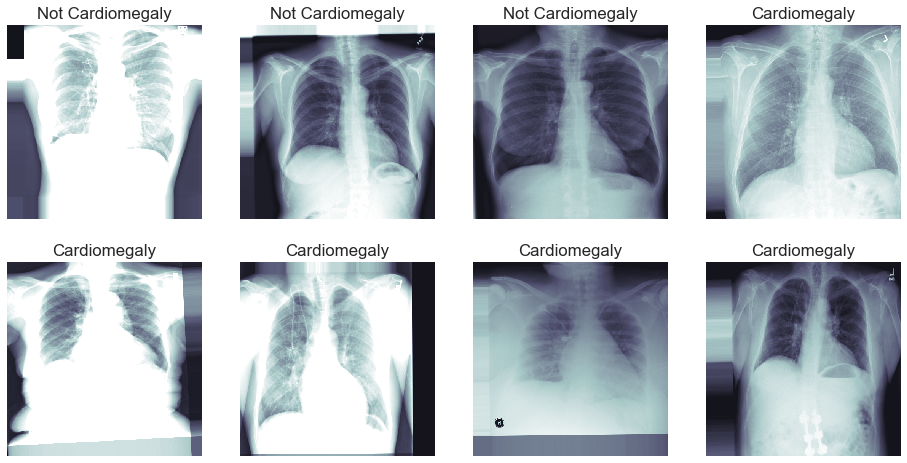

In [233]:
# make some example plots of images with the assigned diagnosis
# x is path data, y is cardiomegaly T/F
t_x, t_y = next(train_gen)
# make 2 x 4 subplots of example images
fig, m_axis = plt.subplots(2, 4, figsize = (16,8))
# cmap = colormap ='bone', vmin and vmax normalize data
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axis.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % ('Cardiomegaly' if c_y == 1.0 else 'Not Cardiomegaly'))
    # turn axis off, added noise not helpful
    c_ax.axis('off')
    #plt.show()
    
#fig.savefig('output/example_chest_xray_diagnosis.pdf')

In [26]:
t_x

array([[[[ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         ...,
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ]],

        [[ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         ...,
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ]],

        [[ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         ...,
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ],
         [ -95.939   , -108.779   , -115.68    ]],

        ...,

        [[-103.939   , -116.779   , -1

In [27]:
t_y

array([False,  True,  True, False,  True,  True,  True,  True])

### Generate pretrained features for a large batch of images to accelerate the training process

In [28]:
# download the PTModel exclude top
base_pretrained_model = PTModel(input_shape = t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

### Attention Model
Global Average Pooling is too simplistic. Some regions of the image are more relevant than others (heart is in the center between ribs...shoulder/arms/neck do not add imformation). Build an attention model to turn pixels in the GAP on and off before pooling and then rescale the lambda layer based on the number of pixels. Somewhat like a 'global weighted average' pooling

### Basic Preprocessing - Take the output of pretrained model (PTModel) and apply BatchNormalization

In [29]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]

from keras.layers import BatchNormalization
bn_features = BatchNormalization(name='Features_BN')(pt_features)

In [30]:
pt_features

<tf.Tensor 'feature_input:0' shape=(None, 16, 16, 512) dtype=float32>

In [31]:
pt_depth

512

In [32]:
bn_features

<tf.Tensor 'Features_BN/cond/Identity:0' shape=(None, 16, 16, 512) dtype=float32>

### Attention outputs a spatial mask of which regions of the pretrained feature map we want to use.  Simple segmentation of the feature map

In [33]:
# first layer bring in batch normalized features; 2D convolution layer over images
# note: 'elu'is an activation function that converges cost to zero faster and possibly more accurate (elu is similar to relu but has negative inputs)
# first integer is the number of output filters in the convolution
# kernel_size specifies the height and width of the 2D convolution window
attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)

# Convolution layer with attn_layer from previous, padding = 'same' means the output has the same lenght as input
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)

# Convolution layer with attn_layer from previous
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)

# average pooling layer to smooth results
attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer)

# Convolution layer with 'sigmoid' activation. sigmoid exist between 0 and 1, great to predict prob as an output. valid means no padding
attn_layer = Conv2D(1, kernel_size = (1, 1), padding = 'valid', activation = 'sigmoid', name = 'AttentionMap2D')(attn_layer)

### Rescale Attention feature dimension back to the original number of features with a hard-coded convolution

In [34]:
# fan out to all channels
up_c2_w = np.ones((1,1,1,pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', name = 'UpscaleAttention', activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

In [35]:
up_c2_w

array([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.

In [36]:
up_c2

### Global Weighted Average Pooling - Use the attention layer to weight the regions we want during the average pooling
Many of the values will be zero and they will be counted, so a standard average pooling layer is poorly suited to this task. Instead for the weighted average = ((attention * features) / sum of the attention)

In [37]:
mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

In [38]:
mask_features 

<tf.Tensor 'multiply_1/mul:0' shape=(None, 16, 16, 512) dtype=float32>

In [39]:
gap_features

<tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(None, 512) dtype=float32>

In [40]:
gap_mask

<tf.Tensor 'global_average_pooling2d_2/Mean:0' shape=(None, 512) dtype=float32>

In [41]:
gap

<tf.Tensor 'RescaleGAP/truediv:0' shape=(None, 512) dtype=float32>

### Dropout and Classifacation
Take output of global weighted-average pooling and classify with dropout and 2 fully connected layers

In [42]:
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

attn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

attn_model.summary()

Model: "attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, 16, 16, 512)  0                                            
__________________________________________________________________________________________________
Features_BN (BatchNormalization (None, 16, 16, 512)  2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  65664       Features_BN[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_1[0][0]                   
____________________________________________________________________________________

In [43]:
gap_dr

<tf.Tensor 'dropout_1/cond/Identity:0' shape=(None, 512) dtype=float32>

In [44]:
dr_steps

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 128) dtype=float32>

In [45]:
out_layer

<tf.Tensor 'dense_2/Sigmoid:0' shape=(None, 1) dtype=float32>

### Show Model Architecture

In [226]:
# for jupyter notebook
# from keras.utils.vis_utils import model_to_dot
# from IPython.display import Image
# Image(model_to_dot(attn_model, show_shapes=True).create_png())

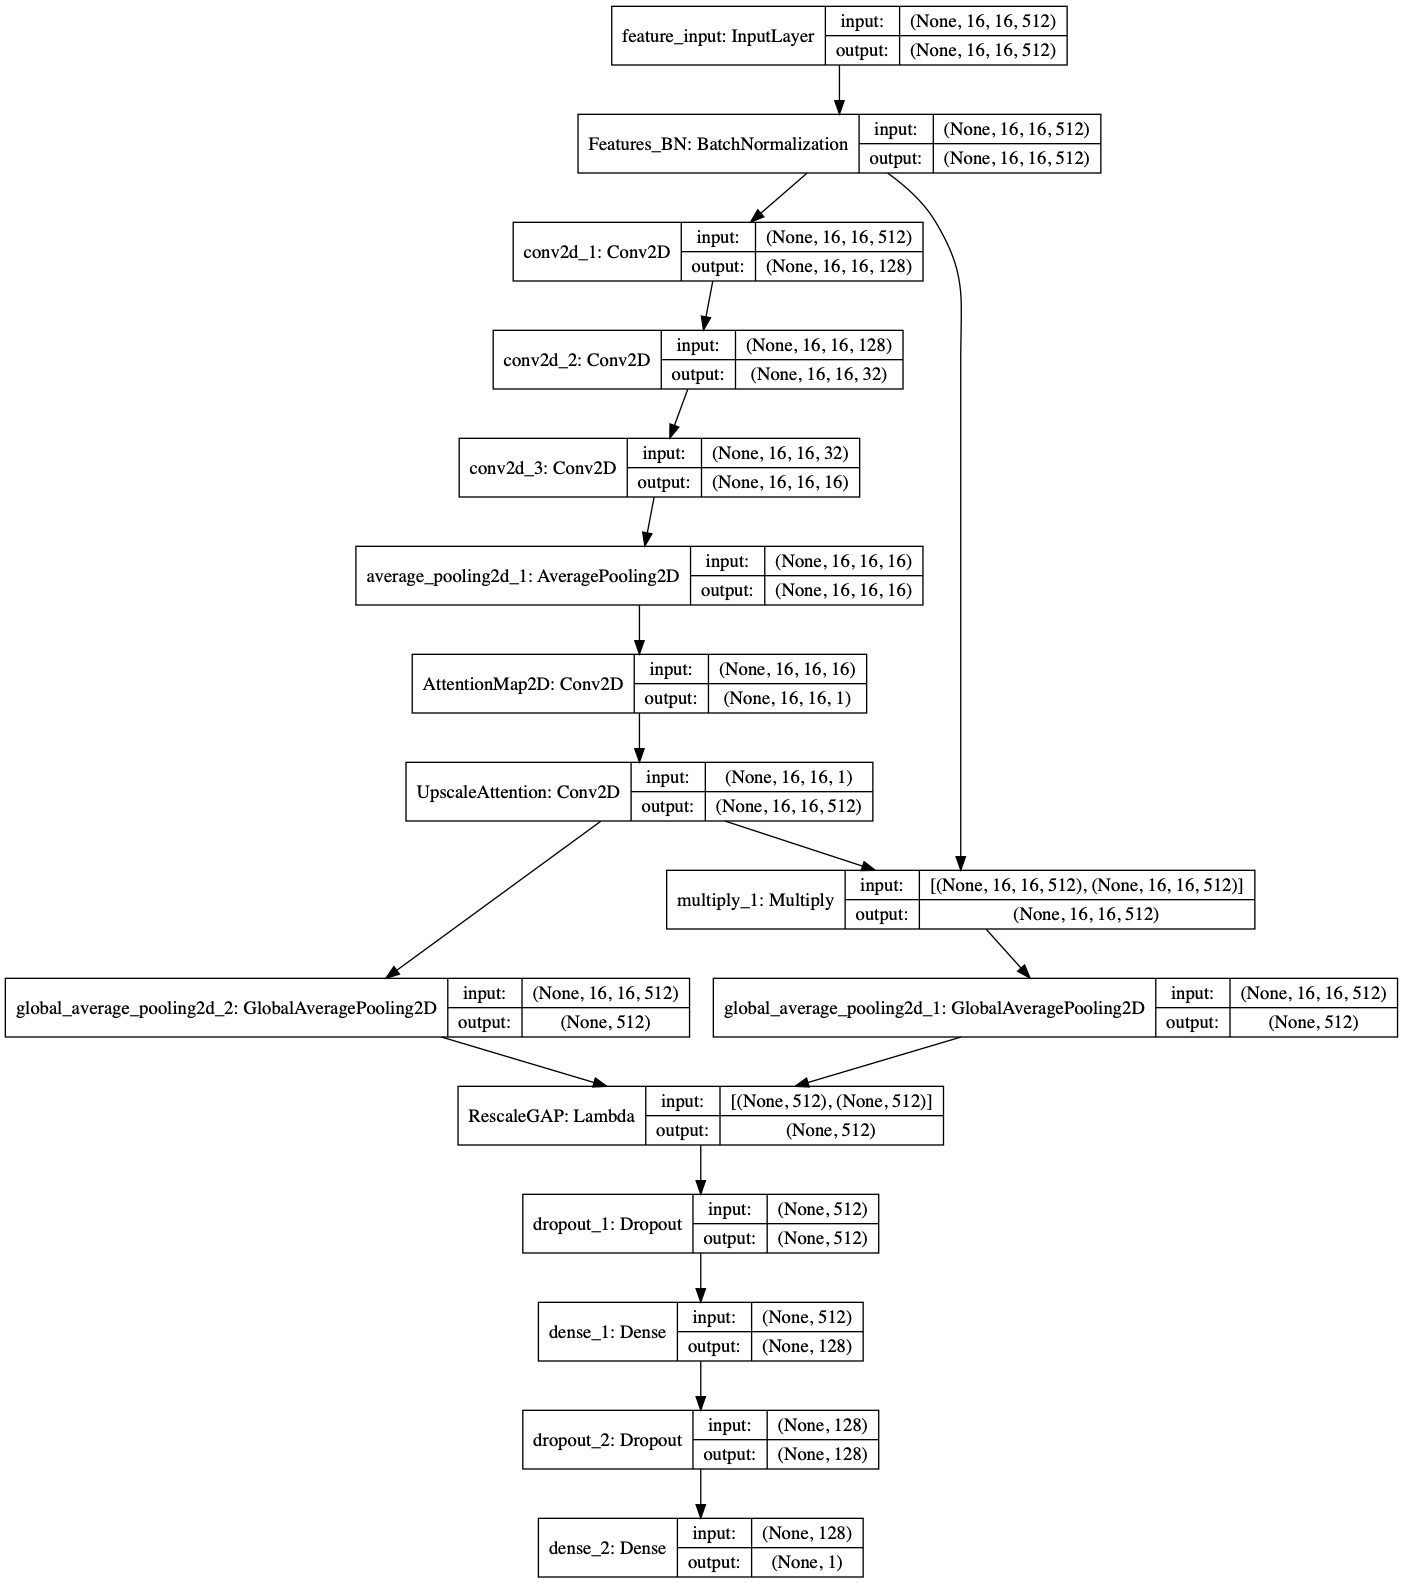

In [227]:
# to save a image .pgn of model architecture
from keras.utils import plot_model
plot_model(attn_model, to_file='output/attn_model_architecture.png', show_shapes=True)

### Use Callbacks during training procedure to get a view on internal states and stats of the model during training

In [49]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="output/{}_weights.best.hdf5".format('cardio_attn')

# save the model after each checkpoint, only save the best overwrite others (val_loss min)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

# Reduce learning rate when a metric has stopped improving
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)

# stop training when a monitored quanity has stopped improving
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [50]:
weight_path

'cardio_attn_weights.best.hdf5'

### Build the Model and fine-tune the results

In [51]:
from keras.models import Sequential
from keras.optimizers import Adam
tb_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
tb_model.add(base_pretrained_model)
tb_model.add(attn_model)
# before training the model you need to configure the learning process via compile, need three arguments an optimizer, loss function, and list of metrics
# loss = objective to minimize in model
# metric = judges the performance of your model
tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
tb_model.summary()

Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
attention_model (Model)      (None, 1)                 138690    
Total params: 14,853,378
Trainable params: 137,154
Non-trainable params: 14,716,224
_________________________________________________________________


In [52]:
#fit_generator trains the model on data generated batch-by-batch by a python generator
train_gen.batch_size = 24
tb_model.fit_generator(train_gen,
                       validation_data = (test_X, test_Y),
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                       epochs=30,
                       callbacks=callbacks_list,
                       workers=3)

Epoch 1/30
166/166 [==============================] - 1428s 9s/step - loss: 0.6590 - binary_accuracy: 0.6094 - val_loss: 0.5976 - val_binary_accuracy: 0.6675

Epoch 00001: val_loss improved from inf to 0.59763, saving model to cardio_attn_weights.best.hdf5
Epoch 2/30
166/166 [==============================] - 1398s 8s/step - loss: 0.5997 - binary_accuracy: 0.6670 - val_loss: 0.6090 - val_binary_accuracy: 0.6375

Epoch 00002: val_loss did not improve from 0.59763
Epoch 3/30
166/166 [==============================] - 1389s 8s/step - loss: 0.5783 - binary_accuracy: 0.6934 - val_loss: 0.6446 - val_binary_accuracy: 0.6300

Epoch 00003: val_loss did not improve from 0.59763
Epoch 4/30
166/166 [==============================] - 1385s 8s/step - loss: 0.5550 - binary_accuracy: 0.7075 - val_loss: 0.5489 - val_binary_accuracy: 0.6825

Epoch 00004: val_loss improved from 0.59763 to 0.54888, saving model to cardio_attn_weights.best.hdf5
Epoch 5/30
166/166 [==============================] - 1394s 8s

### Did Attention Model Learn anything useful?

In [53]:
# select the attention layer
# the attention layer only has a single output dim (None, 16, 16, 1)
for attn_layer in attn_model.layers:
    # attn layer has mulitple nodes so use layer.get_output_shape_at(node_index)
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [54]:
c_shape

(None, 16, 16, 1)

### Plot random chest x-rays and their corresponding attention heat map

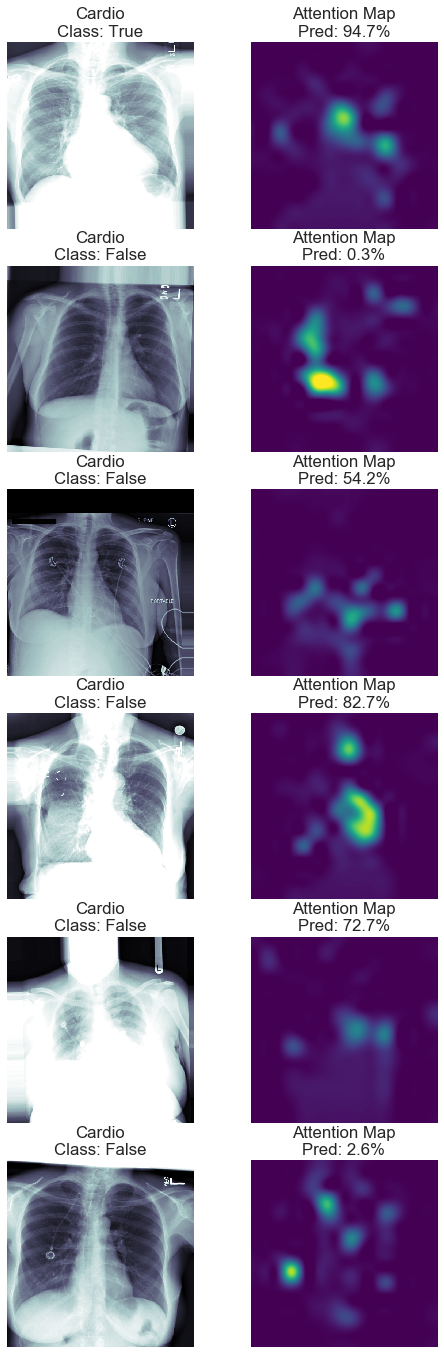

In [220]:
# backend engine of Keras is a specialized, well optimized tensor library (Keras has three backends available TensorFlow, Theano, CNTK). Using abstract backend
import keras.backend as K
# randomly choose 6 index from the test set
rand_idx = np.random.choice(range(len(test_X)), size=6)
# attention backend function(inputs, outputs)
attn_func = K.function(inputs = [attn_model.get_input_at(0), K.learning_phase()], outputs = [attn_layer.get_output_at(0)])
# set up subplots 6x2 
fig, m_axis = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
# turn axis numbers off and flatten subplot axes
[c_ax.axis('off') for c_ax in m_axis.flatten()]
# pair the rand_idx with the c_idx
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axis):
    # select the images from test_X
    cur_img = test_X[c_idx:(c_idx+1)]
    # generate predictions for the input samples
    cur_features = base_pretrained_model.predict(cur_img)
    attn_img = attn_func([cur_features, 0])[0]
    # parameters for image axis
    img_ax.imshow(cur_img[0,:,:,0], cmap ='bone')
    # parameters for attention axis
    attn_ax.imshow(attn_img[0,:,:,0], cmap = 'viridis', vmin = 0, vmax = 1, interpolation = 'lanczos')
    real_label = test_Y[c_idx]
    # add title Cardio and label Cardiomegaly T/F
    img_ax.set_title('Cardio\nClass: %s' % (real_label))
    pred_confidence = tb_model.predict(cur_img)[0]
    # add title to Attention Map with % prediction_confidence
    attn_ax.set_title('Attention Map\nPred: %2.1f%%'% (100*pred_confidence[0]))
    fig.savefig('output/attention_map.png', dpi = 300)

In [61]:
rand_idx

array([265, 311, 354, 254, 175, 151])

In [71]:
c_idx

151

In [65]:
cur_img

array([[[[  93.061   ,   80.221   ,   73.32    ],
         [  93.061   ,   80.221   ,   73.32    ],
         [  93.061   ,   80.221   ,   73.32    ],
         ...,
         [  62.060997,   49.221   ,   42.32    ],
         [  62.060997,   49.221   ,   42.32    ],
         [  62.060997,   49.221   ,   42.32    ]],

        [[  87.061   ,   74.221   ,   67.32    ],
         [  87.061   ,   74.221   ,   67.32    ],
         [  87.061   ,   74.221   ,   67.32    ],
         ...,
         [  62.060997,   49.221   ,   42.32    ],
         [  62.060997,   49.221   ,   42.32    ],
         [  62.060997,   49.221   ,   42.32    ]],

        [[  67.061   ,   54.221   ,   47.32    ],
         [  67.061   ,   54.221   ,   47.32    ],
         [  68.061   ,   55.221   ,   48.32    ],
         ...,
         [  62.060997,   49.221   ,   42.32    ],
         [  62.060997,   49.221   ,   42.32    ],
         [  62.060997,   49.221   ,   42.32    ]],

        ...,

        [[ -87.939   , -100.779   , -1

In [66]:
cur_features

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           2.155423  ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  2.594639  ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.4557904 ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [67]:
attn_img

array([[[[2.34424215e-13],
         [1.71027736e-07],
         [2.32764822e-03],
         [9.37659410e-04],
         [1.10477756e-03],
         [3.40863946e-03],
         [2.08816514e-03],
         [3.86642059e-04],
         [3.49253736e-04],
         [2.48735887e-04],
         [1.55267844e-04],
         [6.50480739e-04],
         [2.47980897e-05],
         [1.02440749e-08],
         [4.20476466e-11],
         [7.01118981e-12]],

        [[8.60986782e-10],
         [4.95450195e-06],
         [4.29242442e-04],
         [6.09064591e-04],
         [1.29729509e-02],
         [8.15003365e-02],
         [6.72740117e-03],
         [3.10873293e-04],
         [1.39951962e-03],
         [1.99580356e-03],
         [5.59108681e-04],
         [2.75902427e-03],
         [2.06008274e-02],
         [3.65558459e-04],
         [2.67383257e-07],
         [2.39076225e-08]],

        [[7.80094269e-05],
         [1.12098211e-03],
         [1.30296510e-03],
         [7.80674745e-04],
         [1.00640813e-02

In [69]:
pred_confidence

array([0.00049937], dtype=float32)

### Evaluate the model.  See how the predictions compare to expected.  
Use validation data that was not directly trained on (note: validation data was used as stopping criteria)

In [72]:
# generate output predictions for the input validation samples(test_X), done in batches
pred_Y = tb_model.predict(test_X,
                          batch_size = 32,
                          verbose = True)

400/400 [==============================] - 132s 331ms/step


### Plot confusion matrix and classifacation report

[[243  79]
 [ 31  47]]


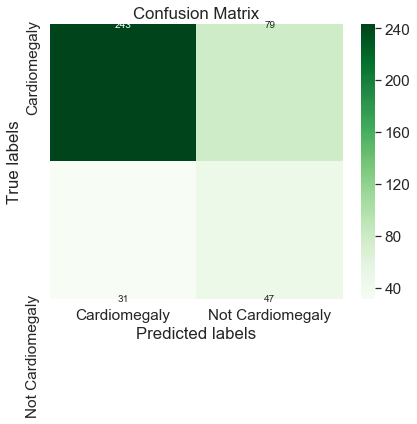

                  precision    recall  f1-score   support

Not Cardiomegaly       0.89      0.75      0.82       322
    Cardiomegaly       0.37      0.60      0.46        78

        accuracy                           0.73       400
       macro avg       0.63      0.68      0.64       400
    weighted avg       0.79      0.72      0.75       400



In [193]:
# print the confusion matrix and classifacation report
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

conmat = confusion_matrix(test_Y, pred_Y>0.5)
print(confusion_matrix(test_Y, pred_Y>0.5))

fig, ax = plt.subplots(figsize=(6,6))

# labels, title and ticks
sns.heatmap(conmat, annot=True, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Cardiomegaly', 'Not Cardiomegaly']) 
ax.yaxis.set_ticklabels(['Cardiomegaly', 'Not Cardiomegaly'])
plt.tight_layout()
plt.show()

# print classifacation report
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Not Cardiomegaly', 'Cardiomegaly']))

### Plot ROC and ROC AUC Score

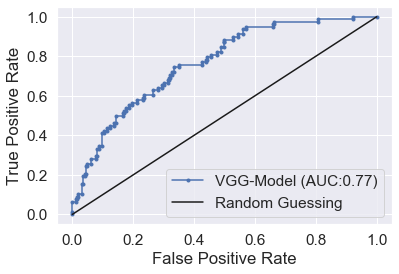

In [198]:
# plot ROC curve and ROC AUC score
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label='Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
fig.savefig('output/roc_validation.pdf')

### Test using final_test data.  True test data has not been used after split.

In [ ]:
final_pred_Y = tb_model.predict(final_test_X,
                                verbose = True,
                                batch_size = 4)

### Final confusion matrix and classifacation report

[[230  76]
 [ 32  62]]


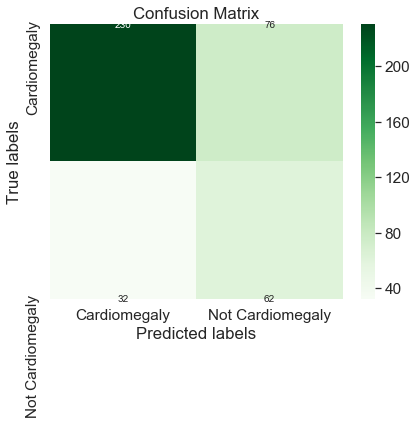

                  precision    recall  f1-score   support

Not Cardiomegaly       0.88      0.75      0.81       306
    Cardiomegaly       0.45      0.66      0.53        94

        accuracy                           0.73       400
       macro avg       0.66      0.71      0.67       400
    weighted avg       0.78      0.73      0.75       400



In [217]:
final_cm = confusion_matrix(final_test_Y, final_pred_Y>0.5)
print(confusion_matrix(final_test_Y, final_pred_Y>0.5))

fig, ax = plt.subplots(figsize=(6,6))

# labels, title and ticks
sns.heatmap(final_cm, annot=True, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Cardiomegaly', 'Not Cardiomegaly'])
ax.yaxis.set_ticklabels(['Cardiomegaly', 'Not Cardiomegaly'])
plt.tight_layout()
plt.show()
fig.savefig('output/confusion_matrix_final.pdf')

# print classifacation report
print(classification_report(final_test_Y, final_pred_Y>0.5, target_names = ['Not Cardiomegaly', 'Cardiomegaly']))

### Final ROC curve and ROC AUC Score

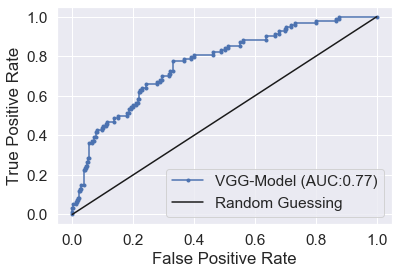

In [197]:
# plot ROC curve and ROC AUC score
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(final_test_Y, final_pred_Y)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(final_test_Y, final_pred_Y))
ax1.plot(fpr, fpr, 'k-', label='Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
fig.savefig('output/roc_final.pdf')

### Export the Model

In [215]:
tb_model.save('output/full_pred_model.h5')

### Export the attention model
Produce attention maps for the image, package the relevant inputs and outputs together

In [218]:
img_in = Input(t_x.shape[1:])
feat_lay = base_pretrained_model(img_in)
just_attn = Model(inputs = attn_model.get_input_at(0),
                  outputs = [attn_layer.get_output_at(0)],
                             name = 'pure_attention')
attn_img = just_attn(feat_lay)
pure_attn_model = Model(inputs = [img_in], outputs = [attn_img], name = 'just_attention_model')
pure_attn_model.save('output/pure_attn_model.h5')
pure_attn_model.summary()

Model: "just_attention_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
pure_attention (Model)       (None, 16, 16, 1)         72385     
Total params: 14,787,073
Trainable params: 71,361
Non-trainable params: 14,715,712
_________________________________________________________________
